<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Hidden_Markov_Model_on_indiavix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hmmlearn
!pip install yfinance

     |████████████████████████████████| 374 kB 27.4 MB/s 
     |████████████████████████████████| 6.3 MB 41.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=3ed339f531ecd423f3df610c4de86b3cb4d8fca9aeebf6b17491813ae4ae4e26
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
from hmmlearn import hmm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
np.random.seed(1)

In [4]:
data_p = pd.read_csv('/content/indiavix.csv')

In [5]:
data_p['date']=data_p.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))

In [6]:
data_p.head(2)

,time,open,high,low,close,Volume,Volume MA,date
0,1369194300,17.879999,18.030001,16.950001,17.719999,NaN,NaN,22-05-2013
1,1369280700,17.719999,19.360001,16.959999,18.730000,NaN,NaN,23-05-2013


In [7]:
data_p=data_p.set_index('date')

In [8]:
data_p=data_p["10-06-2013":]

In [9]:
data_p=data_p.reset_index()

In [10]:
del data_p['time']
del data_p['Volume']
del data_p['Volume MA']

In [11]:
df=data_p.copy()

In [14]:
returns = np.log(df['close']).diff(8)

In [15]:
returns.dropna(inplace=True)

In [16]:
#returns=returns.close

In [17]:
returns.replace([np.inf, -np.inf], np.nan, inplace=True)

In [18]:
returns.dropna(inplace=True)

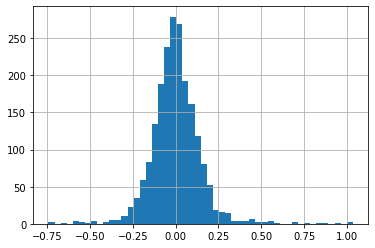

In [19]:
returns.hist(bins=50);

In [20]:
model = hmm.GaussianHMM(n_components=2, n_iter=25,covariance_type="diag")

In [21]:
X = returns.to_numpy().reshape(-1, 1)
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=25, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [22]:
Z = model.predict(X)

In [23]:
Z

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

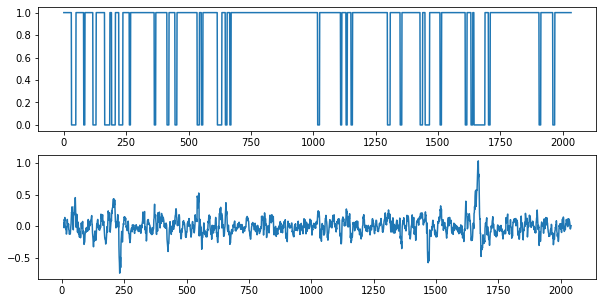

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(211)
plt.plot(Z)
plt.subplot(212)
plt.plot(returns);

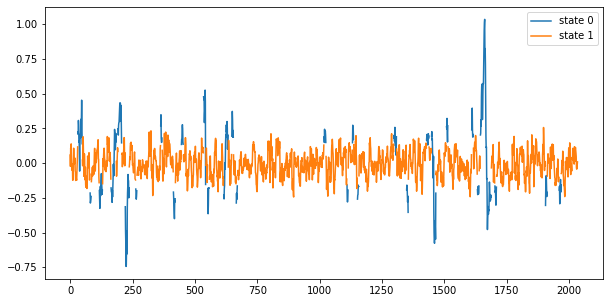

In [25]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))

# first create arrays with nan
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();

In [26]:
# transition matrix
model.transmat_

array([[0.87638016, 0.12361984],
       [0.03015133, 0.96984867]])

In [27]:
'''
# try to set the transition matrix intuitively
model.transmat_ = np.array([
  [0.999, 0.001],
  [0.001, 0.999],                           
])
'''

'\n# try to set the transition matrix intuitively\nmodel.transmat_ = np.array([\n  [0.999, 0.001],\n  [0.001, 0.999],                           \n])\n'

In [28]:
# run inference again
Z = model.predict(X)

zi= pd.concat([df.date,pd.Series(Z)],axis=1)
zi=zi.set_index('date')
zi.columns=['pred']

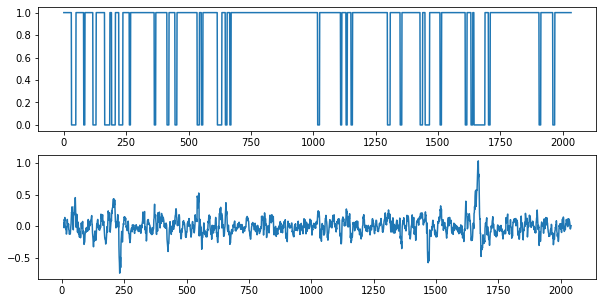

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(211)
plt.plot(Z)
plt.subplot(212)
plt.plot(returns);

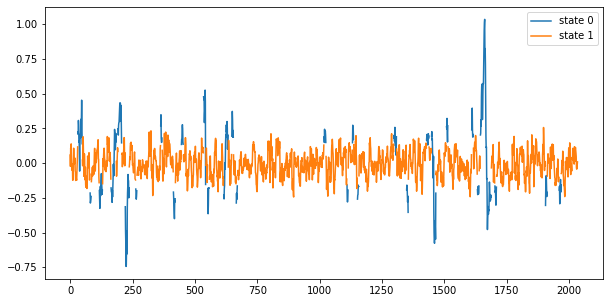

In [30]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))

# first create arrays with nan
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();

In [31]:

def plot_buy_sell_signal(df):
  reg1=[]
  reg2=[]
  for i in range(len(df)):
    if df.pred.iloc[i]==1 and df.pred.iloc[i-1]==0 :
      reg1.append(i)
    elif df.pred.iloc[i]==0 and df.pred.iloc[i-1]==1 :
      reg2.append(i)
  
  return reg1,reg2

In [32]:
sell,buy=plot_buy_sell_signal(zi)

In [33]:
#df['date'] = pd.to_datetime(df['date'])

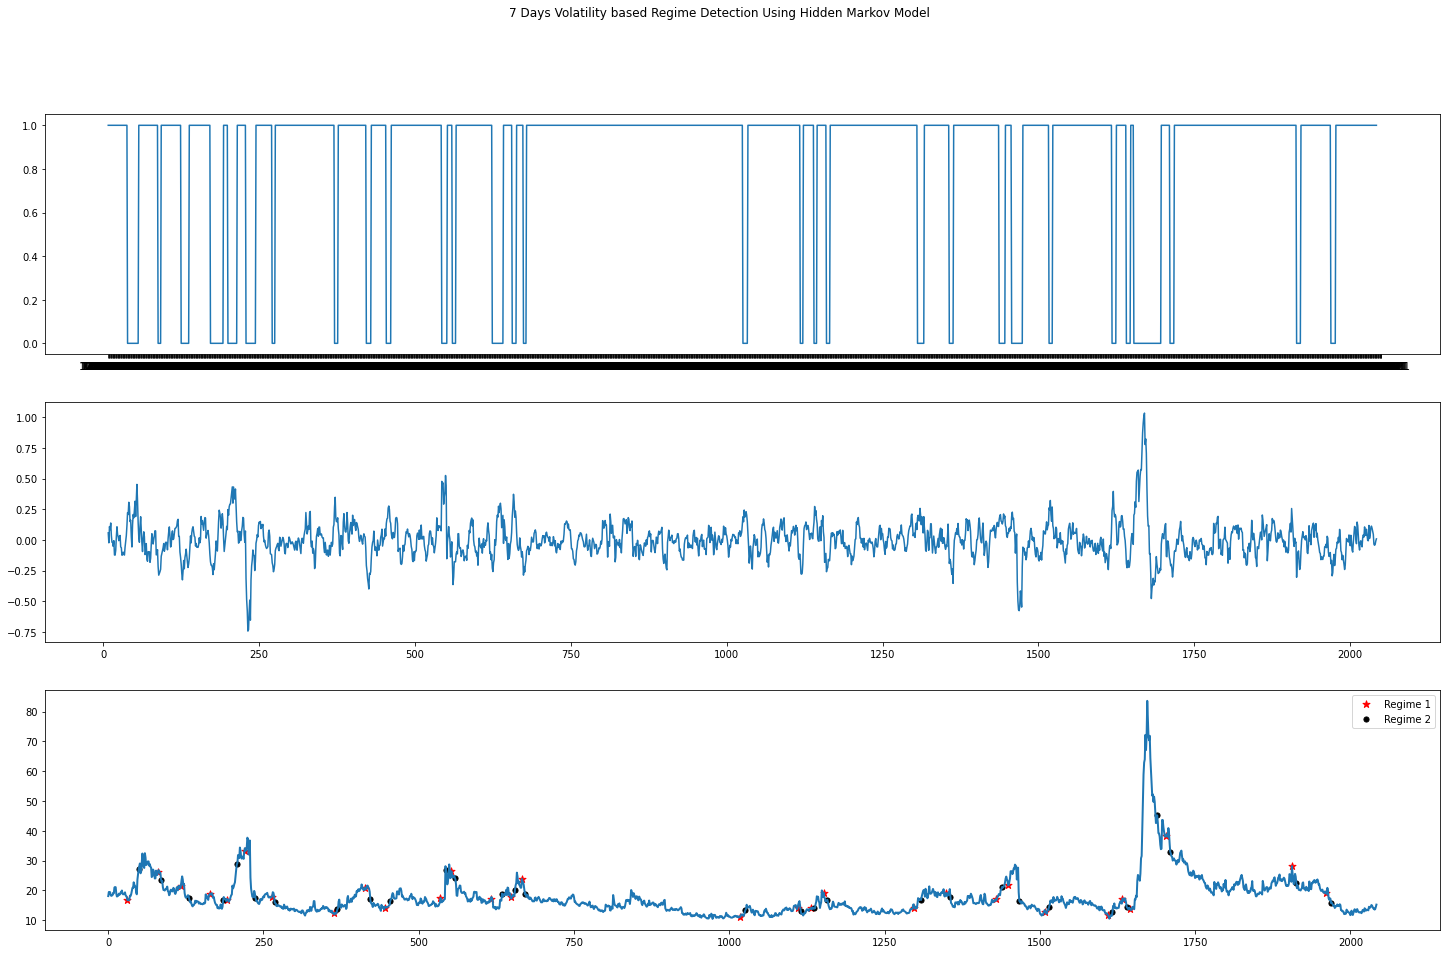

In [34]:
fig, ax = plt.subplots(figsize=(25,15),sharex=True)
plt.subplot(311)
plt.plot(zi[:])
plt.subplot(312)
plt.plot(returns[:])
plt.subplot(313)
plt.plot(df['close'][:],linewidth=2)
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:]['close'],marker='*',s=55,color='r',label='Regime 1')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:]['close'],marker='.',s=105,color='black',label='Regime 2')
plt.legend()
plt.suptitle('7 Days Volatility based Regime Detection Using Hidden Markov Model')
plt.show();